In [271]:
pip install pandas tensorflow scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [317]:
import pandas as pd
df = pd.read_csv('dataset_cleaned.csv', sep=';')
# df = pd.read_csv('dataset_temp.csv', sep=';')
# df = pd.read_csv('dataset_temp_balanced.csv', sep=';')
df['text'] = df['text'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)
print(df['sentiment'].value_counts())
df.head()

sentiment
neutral     12342
positive    12338
negative     4633
Name: count, dtype: int64


,text,sentiment
0,one asian face entire film unbelievable,negative
1,watching movie like make thing hard mind begin...,positive
2,matt damon musnash make look like creepy perv,negative
3,best movie ever,positive
4,went full nuclear man never go full nuclear al...,positive


In [318]:
from gensim.models import FastText
fasttext_model = FastText.load('fasttext_model.bin')
# fasttext_model = FastText.load('fasttext_model_2.bin')
# fasttext_model = FastText.load('fasttext_model_3.bin')
# fasttext_model = FastText.load('fasttext_model_4.bin')

In [319]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(df['text'])
list(tokenizer.word_index.items())[:10]

[('movie', 1),
 ('nolan', 2),
 ('bomb', 3),
 ('oppenheimer', 4),
 ('world', 5),
 ('film', 6),
 ('like', 7),
 ('one', 8),
 ('see', 9),
 ('trailer', 10)]

In [320]:
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index

In [323]:
import numpy as np
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, 4))
for word, i in word_index.items():
    try:
        embedding_vector = fasttext_model.wv[word]
    except:
        print(f'word \"{word}\" is not found')
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

In [324]:
print(vocab_size)
print(embedding_matrix)

20828
[[ 0.50015453  0.82583643  0.79828715  0.03103097]
 [ 3.50773764  0.14345551  2.58872151  2.02103257]
 [ 4.32247877 -0.72758192  1.78831208  4.77459955]
 ...
 [ 0.14798635 -0.39987609  3.98571539 -2.21376395]
 [ 1.32994807 -0.57957053  1.66318262 -0.32659063]
 [ 0.05031028 -0.05765592  0.06508977  0.07102155]]


In [325]:
from keras.preprocessing import sequence
MAX_SEQUENCE_LENGTH = 300
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [326]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
SPLIT_RATIO = 0.2
X = df['text']
y = df['sentiment']
l_encode = LabelEncoder()
l_encode.fit(y)
y = l_encode.transform(y)
y = to_categorical(y, num_classes=3)
X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, test_size=SPLIT_RATIO)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=SPLIT_RATIO)
print(X_train[:10])
print(y_train[:10])

[[  627    10   470 ...     0     0     0]
 [  315    72     0 ...     0     0     0]
 [  348   199   616 ...     0     0     0]
 ...
 [ 4426 12012 12013 ...     0     0     0]
 [    2   157   146 ...     0     0     0]
 [   17   500   108 ...     0     0     0]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [327]:
print(f'X_train: {len(X_train)}')
print(f'y_train: {len(y_train)}\n')

print(f'X_test: {len(X_test)}')
print(f'y_test: {len(y_test)}\n')

print(f'X_val: {len(X_val)}')
print(f'y_val: {len(y_val)}')

assert len(X_train) + len(X_test) + len(X_val) == len(X)

X_train: 18760
y_train: 18760

X_test: 5863
y_test: 5863

X_val: 4690
y_val: 4690


In [328]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, GRU, Activation, Bidirectional, Embedding
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [140]:
# def build_model():
#     sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int64')
    
#     embeddings = Embedding(input_dim=vocab_size, output_dim=15, weights=[embedding_matrix])(sentence_indices)
    
#     X = Bidirectional(GRU(512, return_sequences=True))(embeddings)
    
#     X = Dropout(rate=0.2)(X)
    
#     X = Bidirectional(GRU(512))(embeddings)
    
#     X = Dropout(rate=0.2)(X)
    
#     X = Dense(1024, activation='relu') (X)
    
#     X = Dropout(rate=0.2)(X)
        
#     X = Dense(3, activation='softmax')(X)
    
#     model = Model(inputs=sentence_indices, outputs=X)
    
#     return model

In [329]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int64')
    
    embeddings = Embedding(input_dim=vocab_size, output_dim=4, weights=[embedding_matrix])(sentence_indices)
    
    X = Bidirectional(GRU(16, return_sequences=False))(embeddings)
    
    X = Dropout(rate=0.8)(X)
        
    X = Dense(3, activation='softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [330]:
model = build_model()
model.summary()

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_59 (Embedding)    (None, 300, 4)            83312     
                                                                 
 bidirectional_85 (Bidirect  (None, 32)                2112      
 ional)                                                          
                                                                 
 dropout_84 (Dropout)        (None, 32)                0         
                                                                 
 dense_66 (Dense)            (None, 3)                 99        
                                                                 
Total params: 85523 (334.07 KB)
Trainable params: 85523 (334.07 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [288]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [289]:
import tensorflow as tf


def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [331]:
# adam = Adam(learning_rate=0.001)

model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy', f1])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=200, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=256, epochs=200, validation_data=(X_val, y_val), callbacks=[es], shuffle=True)

Epoch 1/200
74/74 [==============================] - 11s 127ms/step - loss: 0.6651 - accuracy: 0.3949 - f1: 0.3631 - val_loss: 0.6539 - val_accuracy: 0.4876 - val_f1: 0.4059
Epoch 2/200
74/74 [==============================] - 8s 107ms/step - loss: 0.6472 - accuracy: 0.4268 - f1: 0.3954 - val_loss: 0.6249 - val_accuracy: 0.5207 - val_f1: 0.4825
Epoch 3/200
74/74 [==============================] - 8s 112ms/step - loss: 0.6160 - accuracy: 0.4741 - f1: 0.4498 - val_loss: 0.5643 - val_accuracy: 0.5789 - val_f1: 0.5738
Epoch 4/200
74/74 [==============================] - 7s 90ms/step - loss: 0.5729 - accuracy: 0.5318 - f1: 0.5143 - val_loss: 0.5367 - val_accuracy: 0.6011 - val_f1: 0.5981
Epoch 5/200
74/74 [==============================] - 6s 76ms/step - loss: 0.5499 - accuracy: 0.5569 - f1: 0.5419 - val_loss: 0.5241 - val_accuracy: 0.6081 - val_f1: 0.6058
Epoch 6/200
74/74 [==============================] - 6s 75ms/step - loss: 0.5441 - accuracy: 0.5590 - f1: 0.5475 - val_loss: 0.5166 - va

In [291]:
def print_hist(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model af1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [205]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


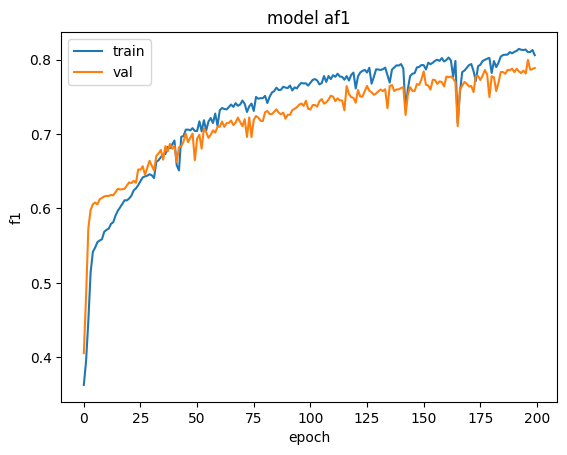

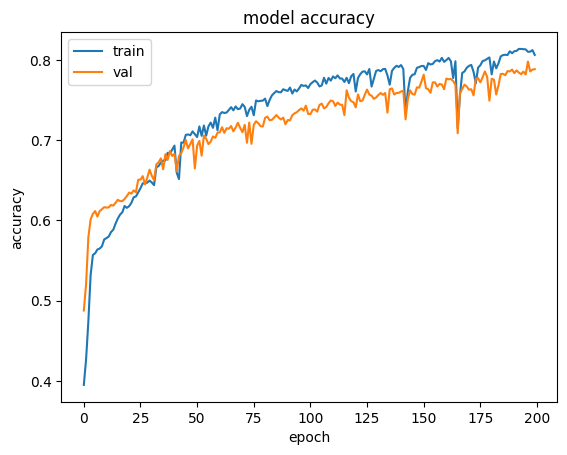

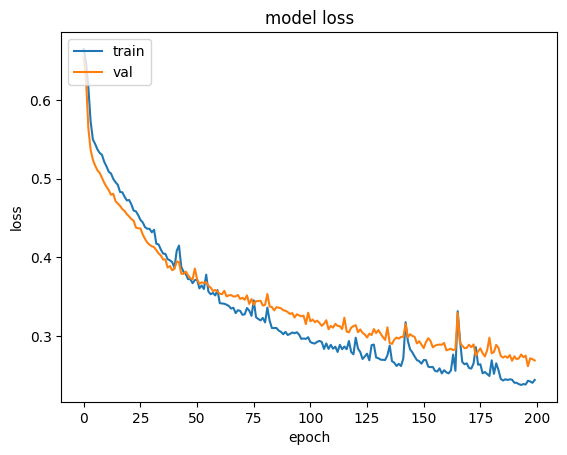

None


In [332]:
print(print_hist(history))

In [311]:
loaded_model = load_model('unbalanced_textblob_1_model.keras')

model.evaluate(X_test, y_test, batch_size=64)

81/81 [==============================] - 1s 7ms/step - loss: 0.1062 - accuracy: 0.8962 - f1: 0.8963


[0.10616619884967804, 0.8962118029594421, 0.8962690830230713]

In [312]:
predict = model.predict(X_test)
encode_predict = np.argmax(predict, axis=1)
label_predict = l_encode.inverse_transform(encode_predict)
for encode, label in zip(encode_predict, label_predict):
    print(encode, label)

162/162 [==============================] - 1s 7ms/step
1 neutral
2 positive
2 positive
2 positive
0 negative
2 positive
0 negative
1 neutral
1 neutral
1 neutral
0 negative
2 positive
0 negative
1 neutral
2 positive
1 neutral
0 negative
1 neutral
2 positive
1 neutral
2 positive
2 positive
1 neutral
0 negative
2 positive
1 neutral
0 negative
1 neutral
2 positive
1 neutral
0 negative
2 positive
0 negative
2 positive
2 positive
0 negative
2 positive
1 neutral
1 neutral
1 neutral
2 positive
1 neutral
2 positive
2 positive
1 neutral
0 negative
0 negative
0 negative
2 positive
1 neutral
1 neutral
1 neutral
1 neutral
0 negative
2 positive
1 neutral
2 positive
1 neutral
2 positive
2 positive
2 positive
2 positive
1 neutral
2 positive
0 negative
0 negative
0 negative
0 negative
1 neutral
0 negative
1 neutral
1 neutral
2 positive
1 neutral
1 neutral
0 negative
0 negative
0 negative
2 positive
0 negative
0 negative
0 negative
1 neutral
1 neutral
2 positive
2 positive
0 negative
0 negative
2 positi

In [333]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm

184/184 [==============================] - 2s 7ms/step


array([[ 546,  161,  255],
       [ 204, 2050,  236],
       [ 207,  167, 2037]])

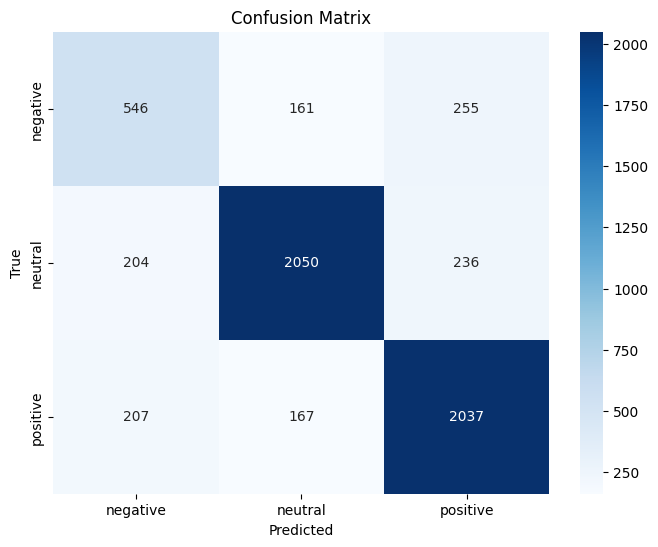

In [334]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [335]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(report)

184/184 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       962
           1       0.86      0.82      0.84      2490
           2       0.81      0.84      0.82      2411

    accuracy                           0.79      5863
   macro avg       0.75      0.75      0.75      5863
weighted avg       0.79      0.79      0.79      5863



In [316]:
model.save('balanced_vader_model_best_256.keras')
model.save('balanced_vader_model_best_256.h5')

/home/g6401201087/Python/myvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
